<a href="https://colab.research.google.com/github/rcortezk9/tensorflow_lessons/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundameantals in TensorFlow

NLP has the goal of deriving infomration out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ccfc4ccc-aca7-1454-76cc-e071dc70cebe)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-06-03 18:33:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-03 18:33:43 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2021-06-03 18:33:45--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.250.73.208, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-06-03 18:33:45 (125 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle Training DataFrame

train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create radom indexes not higher
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target" {target}', '(real diaster)' if target > 0 else '(not real diaster)')
  print(f'text:\n{text}\n')
  print('---\n')

Target" 0 (not real diaster)
text:
2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/VDeFmulx43 http://t.co/yqpAIjSa5g

---

Target" 0 (not real diaster)
text:
Let's fraction the vital need for Our fatalities.  How would you break it down in #education #econom http://t.co/ZSqM8ihE1K

---

Target" 0 (not real diaster)
text:
I love the cotton candy blizzard??

---

Target" 1 (real diaster)
text:
'Jet fuel cant melt steel'
'The structural failure is illogical'
'The second plane crashing into the building is fake'
'It was a bomb'

---

Target" 1 (real diaster)
text:
family members of osama bin laden have died in an airplane accident how ironic ?????? mhmmm gov shit i suspect

---



 ### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_senteces, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                              train_df_shuffled['target'].to_numpy(),
                                              test_size=0.1, # use 10% of training data for valid
                                              random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_senteces), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of a feature vector for each token ( the size of the feature vector can be defined and this embedding can be learned)



### Text vectorization (tokenization)

The processing of each sample contains the following steps:

1. standardize each sample (usually lowercasing + punctuation stripping)
2. split each sample into substrings (usually words)
3. recombine substrings into tokens (usually ngrams)
4. index tokens (associate a unique int value with each token)
5. transform each sample using this index, either into a vector of ints or a dense float vector.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # nax number of words to have in our vacabulary
max_length = 15 # max lenght our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)


In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"

text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataaset and tokenize it
random_sentences = random.choice(train_sentences)
print(f"Original text:\n {random_sentences}\
      \n\nVectorized version:")
text_vectorizer([random_sentences])

Original text:
 Just absolutely obliterated a moth my new purchase is boss      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  29, 1333,  479,    3, 3611,   13,   50, 3502,    9, 2537,    0,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layers:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer='uniform',
                             input_length=max_length)

embedding

In [23]:
# Get a random sentence from the training set
random_sentences = random.choice(train_sentences)
print(f"Original text:\n {random_sentences}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentences]))
sample_embed

Original text:
 @sethalphaeus my personal favorites include paramore muse green day royal blood and 5sos        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03686586, -0.03516798, -0.02806243, ..., -0.00795261,
         -0.04579965, -0.00549843],
        [-0.03553205,  0.02015681, -0.00470025, ..., -0.03943948,
          0.04825595, -0.01266191],
        [ 0.00828812, -0.01864148, -0.03841748, ..., -0.03163831,
         -0.02292379, -0.03009166],
        ...,
        [ 0.00348087, -0.03248797,  0.01874778, ..., -0.04508379,
         -0.04662249, -0.03105145],
        [ 0.02373122, -0.03690962, -0.00513496, ..., -0.03359567,
         -0.04959473, -0.02176545],
        [ 0.02373122, -0.03690962, -0.00513496, ..., -0.03359567,
         -0.04959473, -0.02176545]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentences

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03686586, -0.03516798, -0.02806243, -0.01994519,  0.01185153,
        -0.00398035,  0.0216643 , -0.0356576 , -0.02381568,  0.01641813,
         0.01126159, -0.03111922,  0.03581507, -0.03055692,  0.01535633,
        -0.03608776, -0.02690328,  0.03959295,  0.04898028,  0.01475858,
         0.0497858 ,  0.03005647, -0.01687268,  0.03932998, -0.01039277,
        -0.0101939 , -0.02336186,  0.04816348,  0.03744264, -0.04629183,
         0.01653489, -0.02820017,  0.04308689,  0.00197409,  0.01833656,
         0.04073897,  0.01066816, -0.00034436,  0.01153965, -0.00768969,
        -0.02672439,  0.00857482, -0.03738121,  0.03579731,  0.04081463,
        -0.0109151 ,  0.0352389 ,  0.04089906,  0.00241531, -0.02170998,
         0.01990608, -0.00256781,  0.0180994 , -0.0328009 , -0.03393278,
         0.03044908,  0.03124126,  0.04759211, -0.04611067,  0.04802402,
         0.00048191, -0.0032631 , -0.02240729, -0.02146792, -0.01639904,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a serivews of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is form Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to apporach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model 
* Fit a model
* Evaluate our model



### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert words to number using tfidf
                    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_senteces, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_senteces)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different meics every time, however, this will be cumbersome and could easily be fixed with a function...

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, see the sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classifiction model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, and f1-scrore using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results                   

In [29]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [30]:
# Create a tensorboard callback (need to crate a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [31]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) #turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [32]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [33]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                             y=train_labels,
                             epochs=5,
                             validation_data=(val_senteces, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210603-183353
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6111 - accuracy: 0.6914 - val_loss: 0.5382 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4407 - accuracy: 0.8181 - val_loss: 0.4715 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3472 - accuracy: 0.8631 - val_loss: 0.4663 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2845 - accuracy: 0.8926 - val_loss: 0.4618 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2385 - accuracy: 0.9118 - val_loss: 0.4810 - val_accuracy: 0.7835


In [34]:
# Check the results
model_1.evaluate(val_senteces, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.7835


[0.481014221906662, 0.7834645509719849]

In [35]:
# Make some predictions and evalaute those
model_1_pred_probs = model_1.predict(val_senteces)
model_1_pred_probs.shape

(762, 1)

In [36]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.297008], dtype=float32)

In [37]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.297008  ],
       [0.76439893],
       [0.997577  ],
       [0.11752543],
       [0.11290929],
       [0.93908966],
       [0.9179546 ],
       [0.9903554 ],
       [0.9651878 ],
       [0.2806809 ]], dtype=float32)

In [38]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [39]:
# Calculate our model_1 results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.780192419920975,
 'precision': 0.7888731352165597,
 'recall': 0.7834645669291339}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [41]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learnded embeddings


In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary 
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Get the weight matrix of embedding layer
# (these are the numberical representations of each token in our training data, which have been learne3d for ~5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim(output_dime of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has lwarned to represent our tokens, lets' see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [45]:
# Create embedding files (we go this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequuence data.

The premise of a recurrent neural network is to use the re3presentation of a previous input to adi the representation of a later input.

> 📖 **Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
* MIT's sequence modelling lecture https://youtube/qjrad0V0uJE
* Chris Olah's intro to LSTMs: https://colab.github.io/posts/2015-08-Understanding-LSTMs/
* Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our sturcuture of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_LTSM')])

Saving TensorBoard log files to: model_logs/model_2_LTSM/20210603-183415
Epoch 1/5
215/215 [==============================] - 10s 21ms/step - loss: 0.2232 - accuracy: 0.9219 - val_loss: 0.5392 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1570 - accuracy: 0.9428 - val_loss: 0.5710 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1288 - accuracy: 0.9517 - val_loss: 0.6741 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1060 - accuracy: 0.9596 - val_loss: 0.7920 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0850 - accuracy: 0.9657 - val_loss: 0.8343 - val_accuracy: 0.7782


In [51]:
# Make predictions with LTSM model
model_2_pred_probs = model_2.predict(val_senteces)
model_2_pred_probs[:10]

array([[6.5053920e-03],
       [7.1205676e-01],
       [9.9905950e-01],
       [6.4403757e-02],
       [4.5457366e-04],
       [9.5873815e-01],
       [1.8918218e-01],
       [9.9947387e-01],
       [9.9910069e-01],
       [4.3050405e-01]], dtype=float32)

In [52]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'f1': 0.77403275382623,
 'precision': 0.7858262054194617,
 'recall': 0.7782152230971129}

In [54]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or **gated recurrent unit.**

The GRU cell has similar features to an LSTM cell but has less parameters. 

In [55]:
# Build an RNN using the GRU cell

inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) # When you're stacking RNN cells together, you need to set return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [56]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [58]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210603-183458
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.1552 - accuracy: 0.9381 - val_loss: 0.7979 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0818 - accuracy: 0.9696 - val_loss: 0.7204 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0648 - accuracy: 0.9729 - val_loss: 1.2930 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0540 - accuracy: 0.9777 - val_loss: 0.9896 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0504 - accuracy: 0.9771 - val_loss: 1.3650 - val_accuracy: 0.7612


In [59]:
# Make some predictions with our GRU mode
model_3_pred_probs = model_3.predict(val_senteces)
model_3_pred_probs[:10]

array([[7.5732684e-04],
       [7.5764143e-01],
       [9.9991000e-01],
       [2.3342387e-01],
       [5.2472431e-05],
       [9.9984872e-01],
       [9.5055348e-01],
       [9.9995875e-01],
       [9.9992275e-01],
       [9.9347031e-01]], dtype=float32)

In [60]:
# Convert model 3 pred probs to labels (apples to apples)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 76.11548556430446,
 'f1': 0.7598431815524319,
 'precision': 0.7612627209133627,
 'recall': 0.7611548556430446}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes form right to left as well as left to right

In [62]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [63]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210603-183522
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.1071 - accuracy: 0.9683 - val_loss: 0.8751 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0522 - accuracy: 0.9780 - val_loss: 1.1476 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0484 - accuracy: 0.9774 - val_loss: 1.1897 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0444 - accuracy: 0.9804 - val_loss: 1.3185 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0423 - accuracy: 0.9812 - val_loss: 1.2962 - val_accuracy: 0.7585


In [66]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_senteces)
model_4_pred_probs[:10]

array([[5.8455500e-03],
       [7.3067713e-01],
       [9.9995780e-01],
       [3.0909292e-02],
       [3.2342898e-05],
       [9.9930048e-01],
       [9.8949122e-01],
       [9.9998212e-01],
       [9.9996471e-01],
       [9.9164891e-01]], dtype=float32)

In [67]:
# Convert pred probs to pred lables
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.8530183727034,
 'f1': 0.7573131746360092,
 'precision': 0.7584850115306213,
 'recall': 0.7585301837270341}

In [69]:
model_3_results

{'accuracy': 76.11548556430446,
 'f1': 0.7598431815524319,
 'precision': 0.7612627209133627,
 'recall': 0.7611548556430446}

## Convolution Neural Networks for Text (and other types of sequences) 

We'ver used CNNs for images but images are typically 2d (hight x width)... However, our text data is 1D.

Previously we've Conv2d for our image data but now we're going to use Conv1D.

The typicla sturcture of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically conv1D + pooling) -> Outputs (class probabilites)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (thisis for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://tinyurl.com/y248std8

In [70]:
# Test out our embedding layer, Conv1d layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # Turn target sequece into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=1, # default
                        activation='relu',
                        padding='same') # default = "valid", the output is < input shape, "same" output same as input
conv_1d_output = conv_1d(embedding_test) # Pass test embedding thourgh conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most import feature"or "get the feature with the highest values"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [71]:
# embedding_test

In [72]:
# conv_1d_output

In [73]:
# max_pool_output

In [74]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1d
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [75]:
# Fit the model
model_5_history = model_5.fit(train_sentences, train_labels, epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210603-183630
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.1239 - accuracy: 0.9612 - val_loss: 0.9051 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0773 - accuracy: 0.9714 - val_loss: 1.0110 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0619 - accuracy: 0.9762 - val_loss: 1.1411 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0566 - accuracy: 0.9766 - val_loss: 1.2040 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0524 - accuracy: 0.9777 - val_loss: 1.2496 - val_accuracy: 0.7612


In [76]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_senteces)
model_5_pred_probs[:10]

array([[7.5095549e-02],
       [9.2848605e-01],
       [9.9960798e-01],
       [3.6701649e-02],
       [1.0835636e-08],
       [9.9734050e-01],
       [9.9250507e-01],
       [9.9988389e-01],
       [9.9999976e-01],
       [8.9127898e-01]], dtype=float32)

In [77]:
# convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'f1': 0.7596168376680188,
 'precision': 0.7615445184736523,
 'recall': 0.7611548556430446}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transger learning for NLP, specivically suing TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [80]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [83]:
embed_samples[0].shape

TensorShape([512])

In [84]:
# Create a Keras Layer using the USE pretrained layer form TensorFlow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [97]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


> 🔑 The main drive here is `sentence_encoder_layer`

In [98]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210603-195834
Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.5043 - accuracy: 0.7800 - val_loss: 0.4537 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4164 - accuracy: 0.8127 - val_loss: 0.4417 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4030 - accuracy: 0.8193 - val_loss: 0.4394 - val_accuracy: 0.8031
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3944 - accuracy: 0.8256 - val_loss: 0.4328 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3875 - accuracy: 0.8283 - val_loss: 0.4317 - val_accuracy: 0.8097


In [99]:
# Make predictions with USE TF hub model
model_6_pred_probs = model_6.predict(val_senteces)
model_6_pred_probs[:10]

array([[0.21399142],
       [0.7933916 ],
       [0.9822809 ],
       [0.21251628],
       [0.7834322 ],
       [0.73187864],
       [0.9785847 ],
       [0.9773496 ],
       [0.9264298 ],
       [0.09873639]], dtype=float32)

In [100]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels, y_pred=model_6_preds)
model_6_results

{'accuracy': 80.97112860892388,
 'f1': 0.8086222419416422,
 'precision': 0.8106349122467074,
 'recall': 0.8097112860892388}

In [102]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

> 🧠 **Reminder**

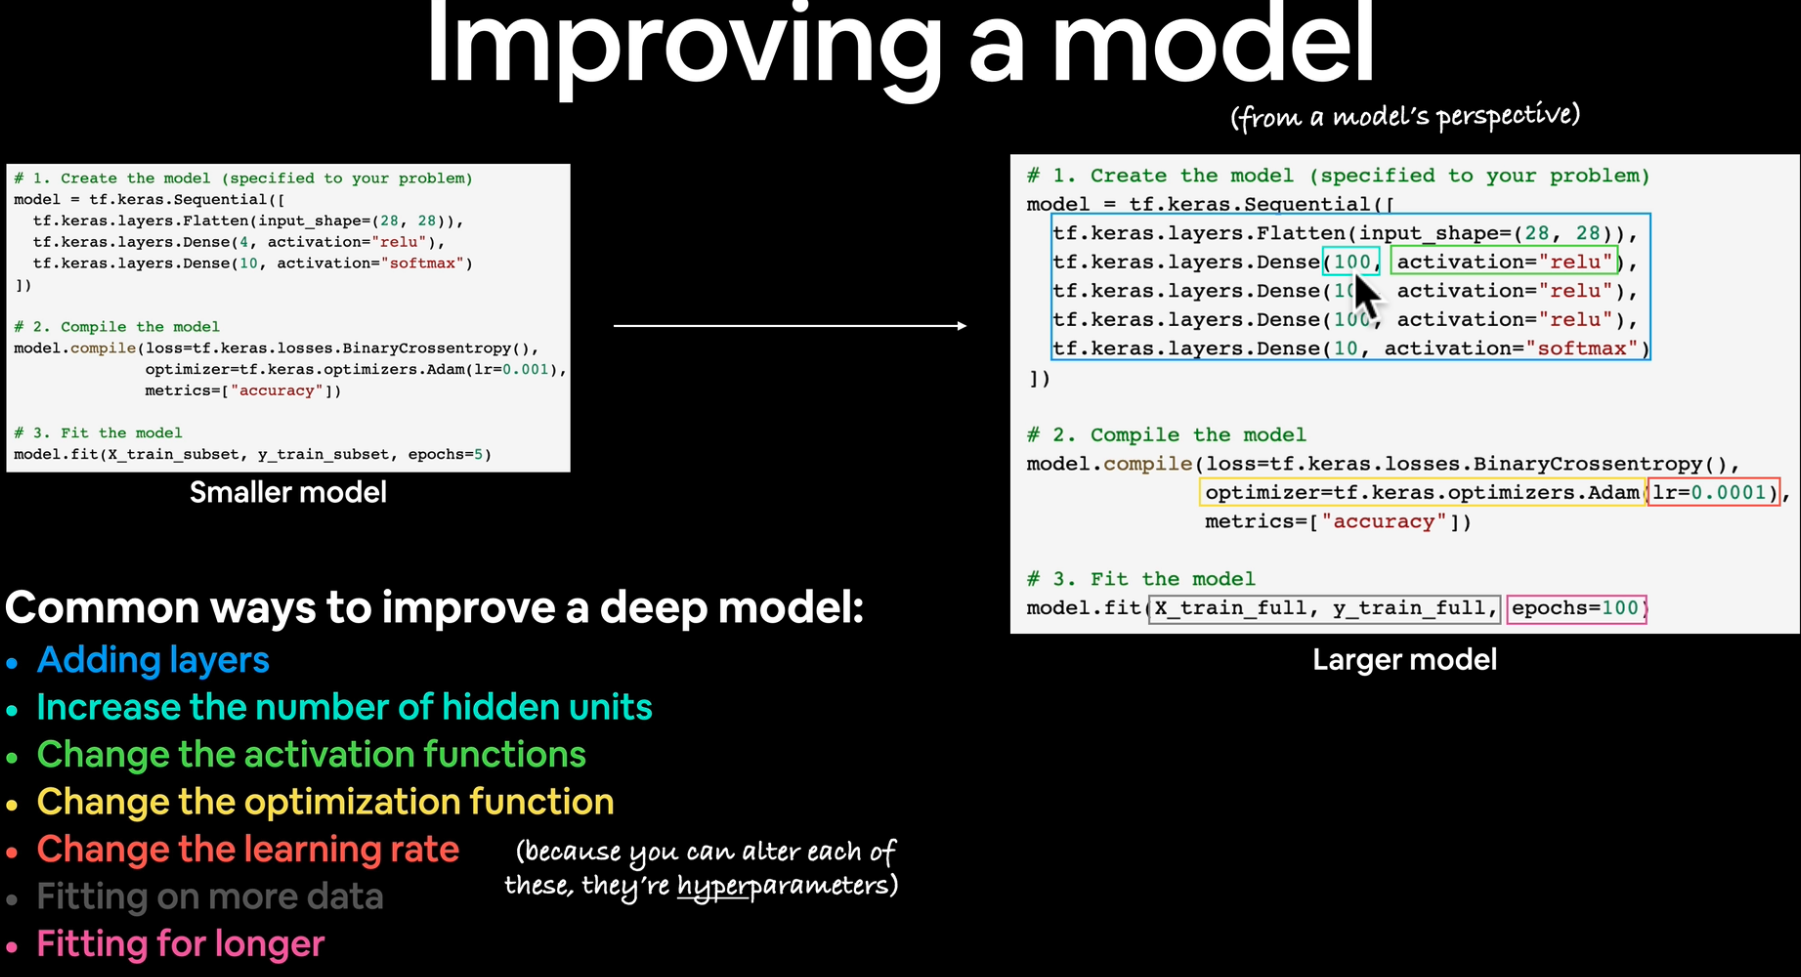

In [103]:
len(train_sentences)

6851

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of that data.

In [105]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [106]:
# Check the number of targets in our subset of data
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [107]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [117]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_7_USE')

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be the same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [118]:
 # Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_senteces, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'tf_hub_sentence_encoder_10_percent ')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent /20210603-204417
Epoch 1/5
24/24 [==============================] - 3s 106ms/step - loss: 0.6759 - accuracy: 0.6557 - val_loss: 0.6405 - val_accuracy: 0.8163
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.6074 - accuracy: 0.8029 - val_loss: 0.5640 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 0.5297 - accuracy: 0.7937 - val_loss: 0.4891 - val_accuracy: 0.8058
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4706 - accuracy: 0.7989 - val_loss: 0.4397 - val_accuracy: 0.8110
Epoch 5/5
24/24 [==============================] - 0s 19ms/step - loss: 0.4301 - accuracy: 0.8121 - val_loss: 0.4100 - val_accuracy: 0.8294


In [119]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_senteces)
model_7_pred_probs[:10]

array([[0.29036248],
       [0.81364447],
       [0.8992024 ],
       [0.31730726],
       [0.80680996],
       [0.85129327],
       [0.8888769 ],
       [0.93852973],
       [0.82078964],
       [0.07024022]], dtype=float32)

In [120]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [121]:
# Evalaute model 7b predictions
model_7_results = calculate_results(y_true=val_labels, y_pred=model_7_preds)
model_7_results

{'accuracy': 82.93963254593176,
 'f1': 0.8291707801295185,
 'precision': 0.8292333273848194,
 'recall': 0.8293963254593176}

In [123]:
model_6_results

{'accuracy': 80.97112860892388,
 'f1': 0.8086222419416422,
 'precision': 0.8106349122467074,
 'recall': 0.8097112860892388}